In [4]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
from flax.training import train_state
import tensorflow as tf
from PIL import Image
import numpy as np
from tqdm.auto import tqdm

In [5]:
!pip install --upgrade kagglehub


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: kagglehub
    Found existing installation: kagglehub 0.3.5
    Uninstalling kagglehub-0.3.5:
      Successfully uninstalled kagglehub-0.3.5


In [6]:
import os
import kagglehub
import shutil

dataset_path = kagglehub.dataset_download("splcher/animefacedataset")

extract_path = "anime_images"
os.makedirs(extract_path, exist_ok=True)

image_dir = os.path.join(dataset_path, "images")
for file in os.listdir(image_dir):
    src = os.path.join(image_dir, file)
    dst = os.path.join(extract_path, file)
    if os.path.isfile(src):
        shutil.copy2(src, dst)


100%|██████████| 395M/395M [00:04<00:00, 90.6MB/s]

Extracting files...


In [7]:
def load_dataset(batch_size=32):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        extract_path,
        label_mode=None,
        image_size=(64, 64),
        batch_size=batch_size,
        shuffle=True,
    )
    def preprocess(x):
        return tf.cast(x, tf.float32) / 127.5 - 1
    return dataset.map(preprocess).as_numpy_iterator()


In [8]:
class UNet(nn.Module):
    def setup(self):
        kernel_init = nn.initializers.orthogonal()
        # Encoder
        self.conv1 = nn.Conv(32, (3, 3), padding="SAME", kernel_init=kernel_init)
        self.conv2 = nn.Conv(64, (3, 3), padding="SAME", kernel_init=kernel_init)
        self.conv3 = nn.Conv(128, (3, 3), padding="SAME", kernel_init=kernel_init)
        self.conv4 = nn.Conv(256, (3, 3), padding="SAME", kernel_init=kernel_init)


        # Group Normalization
        self.gn1 = nn.GroupNorm(num_groups=8)
        self.gn2 = nn.GroupNorm(num_groups=8)
        self.gn3 = nn.GroupNorm(num_groups=8)
        self.gn4 = nn.GroupNorm(num_groups=8)

        # Decoder with skip connections
        self.tconv1 = nn.ConvTranspose(128, (3, 3), padding="SAME")
        self.tconv2 = nn.ConvTranspose(64, (3, 3), padding="SAME")
        self.tconv3 = nn.ConvTranspose(32, (3, 3), padding="SAME")
        self.tconv4 = nn.ConvTranspose(3, (3, 3), padding="SAME")

        self.time_mlp = nn.Dense(32)

    def __call__(self, x, t):
        t = self.time_mlp(t)
        t = jnp.expand_dims(jnp.expand_dims(t, 1), 1)

        # LeakyReLU and GroupNorm
        x1 = jax.nn.leaky_relu(self.gn1(self.conv1(x)), 0.2)
        x2 = jax.nn.leaky_relu(self.gn2(self.conv2(x1)), 0.2)
        x3 = jax.nn.leaky_relu(self.gn3(self.conv3(x2)), 0.2)
        x4 = jax.nn.leaky_relu(self.gn4(self.conv4(x3)), 0.2)

        x = jax.nn.leaky_relu(self.tconv1(x4), 0.2)
        x = x + x3 * 0.1
        x = jax.nn.leaky_relu(self.tconv2(x), 0.2)
        x = x + x2 * 0.1
        x = jax.nn.leaky_relu(self.tconv3(x), 0.2)
        x = x + x1 * 0.1
        x = self.tconv4(x)
        return x


In [9]:
def get_noise_schedule(timesteps=1000):
    beta = np.linspace(1e-4, 0.02, timesteps)
    alpha = 1 - beta
    alpha_bar = np.cumprod(alpha)
    return jnp.array(alpha_bar)


In [10]:
@jax.jit
def diffusion_step(key, x_0, t, alpha_bar):
  noise=jax.random.normal(key, x_0.shape)
  mean=jnp.sqrt(alpha_bar[t])[:, None, None, None]*x_0
  variance=jnp.sqrt(1-alpha_bar[t])[:, None, None, None]
  return mean+variance*noise, noise

In [11]:
class TrainState(train_state.TrainState):
    key: jax.random.PRNGKey

In [12]:
@jax.jit
def train_step(state, batch):
    key, subkey = jax.random.split(state.key)

    def loss_fn(params):
        t = jax.random.randint(subkey, (batch.shape[0],), 0, 1000)
        t_embed = jnp.expand_dims(t/1000, 1)
        noisy_images, noise = diffusion_step(key, batch, t, alpha_bar)
        pred_noise = state.apply_fn({'params': params}, noisy_images, t_embed)
        return jnp.mean(jnp.square(pred_noise-noise) + 1e-8) * 0.01

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss


In [13]:
key = jax.random.PRNGKey(0)
model = UNet()
alpha_bar = get_noise_schedule()
dataset = load_dataset(batch_size=32)
first_batch = jnp.array(next(dataset))
variables = model.init(key, first_batch, jnp.ones((first_batch.shape[0], 1)))

tx = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(
        learning_rate=2e-4,
        b1=0.9,
        b2=0.999,
        eps=1e-8
    )
)



state = TrainState.create(
    apply_fn=model.apply,
    params=variables['params'],
    tx=tx,
    key=key
)


Found 63565 files.


In [14]:
def train(state, dataset, num_epochs=30):
    for epoch in range(num_epochs):
        epoch_losses = []
        for batch in dataset:
            batch = jnp.array(batch)
            # gradient scaling to prevent vanishing gradients
            state, loss = train_step(state, batch)
            epoch_losses.append(loss)

        if epoch_losses:
            avg_loss = jnp.mean(jnp.array(epoch_losses))
            print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

        dataset = load_dataset(batch_size=32)
    return state


In [15]:
dataset = load_dataset()
trained_state = train(state, dataset)

Found 63565 files.
Epoch 0, Loss: 0.000760
Found 63565 files.
Epoch 1, Loss: 0.000425
Found 63565 files.
Epoch 2, Loss: 0.000328
Found 63565 files.
Epoch 3, Loss: 0.000268
Found 63565 files.
Epoch 4, Loss: 0.000219
Found 63565 files.
Epoch 5, Loss: 0.000208
Found 63565 files.
Epoch 6, Loss: 0.000164
Found 63565 files.
Epoch 7, Loss: 0.000207
Found 63565 files.
Epoch 8, Loss: 0.000137
Found 63565 files.
Epoch 9, Loss: 0.000127
Found 63565 files.
Epoch 10, Loss: 0.000117
Found 63565 files.
Epoch 11, Loss: 0.000104
Found 63565 files.
Epoch 12, Loss: 0.000099
Found 63565 files.
Epoch 13, Loss: 0.000115
Found 63565 files.
Epoch 14, Loss: 0.000079
Found 63565 files.
Epoch 15, Loss: 0.000084
Found 63565 files.
Epoch 16, Loss: 0.000076
Found 63565 files.
Epoch 17, Loss: 0.000071
Found 63565 files.
Epoch 18, Loss: 0.000070
Found 63565 files.
Epoch 19, Loss: 0.000071
Found 63565 files.
Epoch 20, Loss: 0.000060
Found 63565 files.
Epoch 21, Loss: 0.000061
Found 63565 files.
Epoch 22, Loss: 0.00005

  0%|          | 0/1000 [00:00<?, ?it/s]

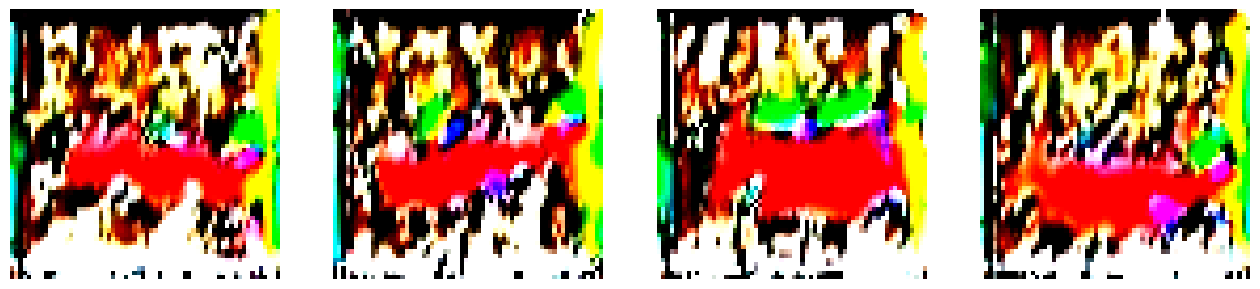

Array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [1.        , 1.        , 0.232508  ],
         [1.        , 1.        , 0.        ],
         [0.62819034, 0.86953205, 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.9036294 , 0.9565114 , 0.        ],
         [1.        , 1.        , 0.        ],
         [1.        , 1.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [1.        , 1.        , 0.        ],
         [1.        , 1.        , 0.        ],
         [1.        , 1.        , 0.        ]],

        ...,

        [[0.6340411 , 0.35929978, 0.23752919],
         [1.        , 1.        , 1.        ]

In [16]:
import matplotlib.pyplot as plt
def generate_and_plot_images(state, num_images=4, save_path=None):
    # Initialize noise with scaling
    key = state.key
    x = jax.random.normal(key, (num_images, 64, 64, 3)) * 0.1

    # Reverse diffusion process
    for t in tqdm(range(999, -1, -1)):
        key, subkey = jax.random.split(key)
        t_embed = jnp.ones((num_images, 1)) * (t / 1000)

        # Predict noise with numerical stability
        pred_noise = state.apply_fn(
            {'params': state.params},
            x + 1e-5,
            t_embed
        )

        # Denoising step with stability measures
        alpha_t = jnp.sqrt(alpha_bar[t])
        sigma_t = jnp.sqrt(1 - alpha_bar[t])
        x = jnp.clip(
            (x - pred_noise * sigma_t) / (alpha_t + 1e-5),
            -2, 2
        )

    # Normalize and clip images
    images = jnp.clip((x + 1) / 2.0, 0, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(num_images*4, 4))
    for i, ax in enumerate(axes):
        img = np.asarray(images[i])
        if np.isnan(img).any():
            img = np.zeros_like(img)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        for i, img in enumerate(images):
            img = np.asarray((img * 255)).astype(np.uint8)
            Image.fromarray(img).save(os.path.join(save_path, f'generated_{i}.png'))

    return images

# To display and save:
# generated_images = generate_and_plot_images(trained_state, save_path='generated_images')

generate_and_plot_images(trained_state)
